### Импортируем библиотеки

In [54]:
import pandas as pd
from pandas import Series
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

import credit_scoring_kernel_module as my

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sf-dst-scoring/sample_submission.csv
/kaggle/input/sf-dst-scoring/test.csv
/kaggle/input/sf-dst-scoring/train.csv


In [55]:
import warnings
warnings.filterwarnings("ignore")

In [56]:
train = pd.read_csv('/kaggle/input/sf-dst-scoring/train.csv')
test= pd.read_csv('/kaggle/input/sf-dst-scoring/test.csv')

In [57]:
train.head(2)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0


Получим информацию о датасетах

In [58]:
train.info(), test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

(None, None)

In [59]:
train.columns, test.columns

(Index(['client_id', 'app_date', 'education', 'sex', 'age', 'car', 'car_type',
        'decline_app_cnt', 'good_work', 'score_bki', 'bki_request_cnt',
        'region_rating', 'home_address', 'work_address', 'income', 'sna',
        'first_time', 'foreign_passport', 'default'],
       dtype='object'),
 Index(['client_id', 'app_date', 'education', 'sex', 'age', 'car', 'car_type',
        'decline_app_cnt', 'good_work', 'score_bki', 'bki_request_cnt',
        'region_rating', 'home_address', 'work_address', 'income', 'sna',
        'first_time', 'foreign_passport'],
       dtype='object'))

Описания полей датасета

- client_id - идентификатор клиента
- education - уровень образования
- sex - пол заемщика
- age - возраст заемщика
- car - флаг наличия автомобиля
- car_type - флаг автомобиля иномарки
- decline_app_cnt - количество отказанных прошлых заявок
- good_work - флаг наличия “хорошей” работы
- bki_request_cnt - количество запросов в БКИ
- home_address - категоризатор домашнего адреса
- work_address - категоризатор рабочего адреса
- income - доход заемщика
- foreign_passport - наличие загранпаспорта
- sna - связь заемщика с клиентами банка
- first_time - давность наличия информации о заемщике
- score_bki - скоринговый балл по данным из БКИ
- region_rating - рейтинг региона
- app_date - дата подачи заявки
- default - флаг дефолта по кредиту

Проверим наличие пропусков в датасете

In [60]:
train.isnull().sum(), test.isnull().sum()

(client_id             0
 app_date              0
 education           307
 sex                   0
 age                   0
 car                   0
 car_type              0
 decline_app_cnt       0
 good_work             0
 score_bki             0
 bki_request_cnt       0
 region_rating         0
 home_address          0
 work_address          0
 income                0
 sna                   0
 first_time            0
 foreign_passport      0
 default               0
 dtype: int64,
 client_id             0
 app_date              0
 education           171
 sex                   0
 age                   0
 car                   0
 car_type              0
 decline_app_cnt       0
 good_work             0
 score_bki             0
 bki_request_cnt       0
 region_rating         0
 home_address          0
 work_address          0
 income                0
 sna                   0
 first_time            0
 foreign_passport      0
 dtype: int64)

Для наглядности посмотрим на данный признак на графике

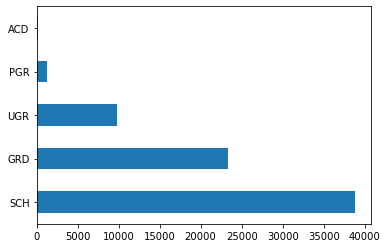

In [61]:
train['education'].value_counts().plot.barh()

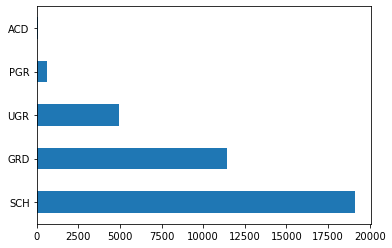

In [62]:
test['education'].value_counts().plot.barh()

Заполним пропуски значением, которое встречается чаще всего

In [63]:
# fill NaN with the most frequent value

import collections

c_1 = collections.Counter(train['education'])
c_2 = collections.Counter(test['education'])

train['education'].fillna(c_1.most_common()[0][0], inplace=True)
test['education'].fillna(c_2.most_common()[0][0], inplace=True)

Проверим успешность заполнения

In [64]:
train.isnull().sum(), test.isnull().sum()

(client_id           0
 app_date            0
 education           0
 sex                 0
 age                 0
 car                 0
 car_type            0
 decline_app_cnt     0
 good_work           0
 score_bki           0
 bki_request_cnt     0
 region_rating       0
 home_address        0
 work_address        0
 income              0
 sna                 0
 first_time          0
 foreign_passport    0
 default             0
 dtype: int64,
 client_id           0
 app_date            0
 education           0
 sex                 0
 age                 0
 car                 0
 car_type            0
 decline_app_cnt     0
 good_work           0
 score_bki           0
 bki_request_cnt     0
 region_rating       0
 home_address        0
 work_address        0
 income              0
 sna                 0
 first_time          0
 foreign_passport    0
 dtype: int64)

Взглянем поближе на признак app_date

In [65]:
train.app_date.head(5), test.app_date.head(5)

(0    01FEB2014
 1    12MAR2014
 2    01FEB2014
 3    23JAN2014
 4    18APR2014
 Name: app_date, dtype: object,
 0    22MAR2014
 1    24JAN2014
 2    23MAR2014
 3    03FEB2014
 4    04FEB2014
 Name: app_date, dtype: object)

Сконветируем формат даты к удобному для работы

In [66]:
# convert to datetime

train.app_date = pd.to_datetime(train.app_date)
test.app_date = pd.to_datetime(test.app_date)
print(train.app_date.head(2))
print(test.app_date.head(2))

0   2014-02-01
1   2014-03-12
Name: app_date, dtype: datetime64[ns]
0   2014-03-22
1   2014-01-24
Name: app_date, dtype: datetime64[ns]


In [67]:
train.head(2)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,2014-02-01,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,2014-03-12,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0


На основе признака app_date создадим новые признаки

In [68]:
current_date = pd.to_datetime('28JUL2020')

# Количество дней, прошедших со дня подачи заявки

train['days_passed'] = (current_date - train.app_date).dt.days
test['days_passed'] = (current_date - test.app_date).dt.days

# Месяц подачи заявки

train['app_date_month'] = train.app_date.dt.month
test['app_date_month'] = test.app_date.dt.month

# День недели подачи заявки

train['app_date_weekday'] = train.app_date.apply(lambda dt: dt.isoweekday())
test['app_date_weekday'] = test.app_date.apply(lambda dt: dt.isoweekday())

Полученные признаки сгруппируем в три категории по типу их обработки (категориальные, бинарные и числовые) для дальнейшего удобного анализа.

In [69]:
train.head(2)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,home_address,work_address,income,sna,first_time,foreign_passport,default,days_passed,app_date_month,app_date_weekday
0,25905,2014-02-01,SCH,M,62,Y,Y,0,0,-2.008753,...,1,2,18000,4,1,N,0,2369,2,6
1,63161,2014-03-12,SCH,F,59,N,N,0,0,-1.532276,...,2,3,19000,4,1,N,0,2330,3,3


In [70]:
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
cat_cols = ['app_date_month', 'app_date_weekday', 'education', 'home_address', 'work_address', 'sna', 'first_time']
num_cols = ['days_passed', 'age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'region_rating', 'income']

## Визуализация

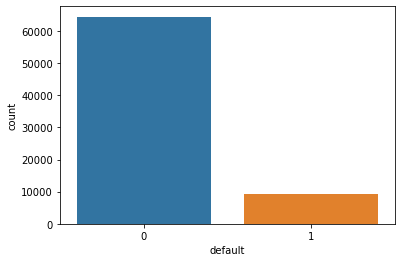

In [71]:
sns.countplot(train['default'])

In [72]:
train['default'].value_counts()

0    64427
1     9372
Name: default, dtype: int64

Очевидно что выборка распределена неравномерно и недефолтных клиентов заметно больше

Построим графики распределения численных переменных

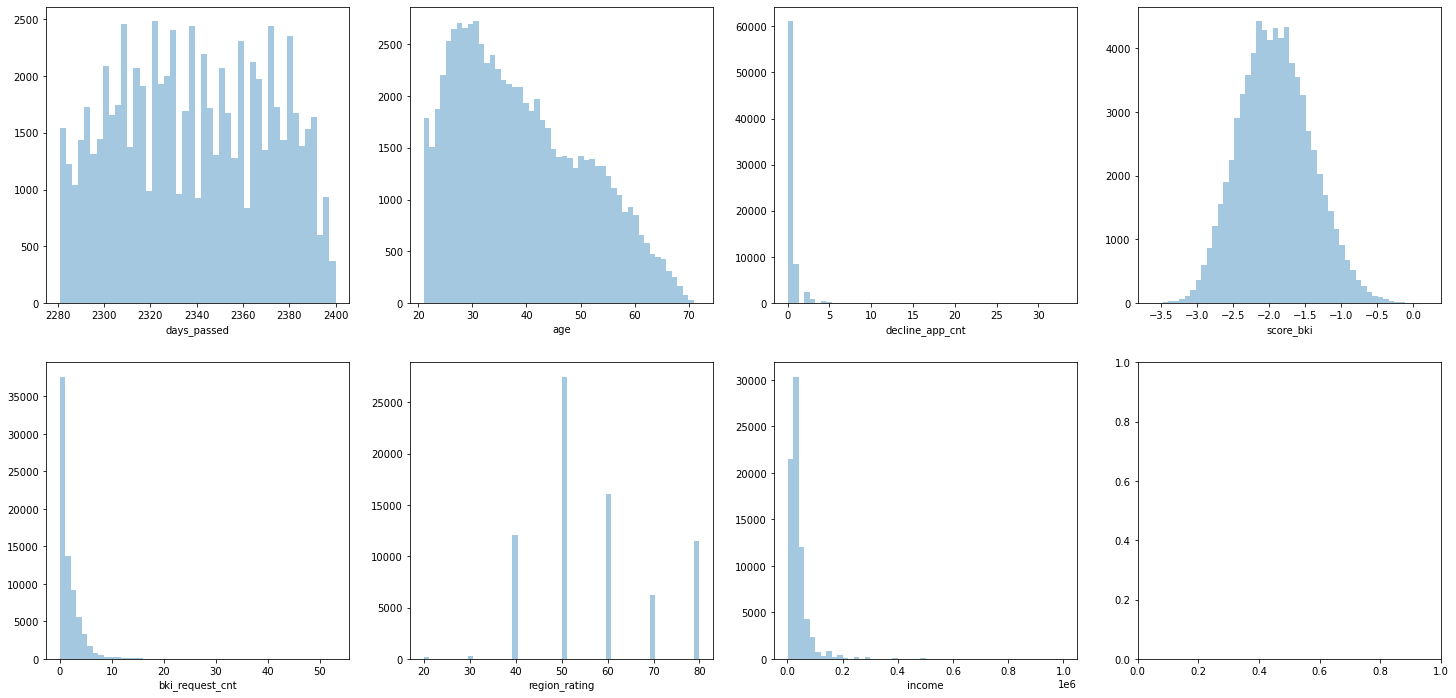

In [73]:
fig, axes = plt.subplots(2, 4, figsize=(25,12))
for col, i in zip(num_cols, range(7)):
    sns.distplot(train[col], kde=False, ax=axes.flat[i])

In [74]:
train[num_cols].describe()

,days_passed,age,decline_app_cnt,score_bki,bki_request_cnt,region_rating,income
count,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000
mean,2338.964566,39.280641,0.275749,-1.904724,2.000339,56.725701,41099.775417
std,32.121884,11.520378,0.804272,0.498231,2.252073,13.055717,46166.322400
min,2281.000000,21.000000,0.000000,-3.624586,0.000000,20.000000,1000.000000
25%,2311.000000,30.000000,0.000000,-2.259534,0.000000,50.000000,20000.000000
50%,2338.000000,37.000000,0.000000,-1.920823,1.000000,50.000000,30000.000000
75%,2367.000000,48.000000,0.000000,-1.569831,3.000000,60.000000,48000.000000
max,2400.000000,72.000000,33.000000,0.199773,53.000000,80.000000,1000000.000000


Прологарифмируем переменные, которые вызывают вопросы в распределении

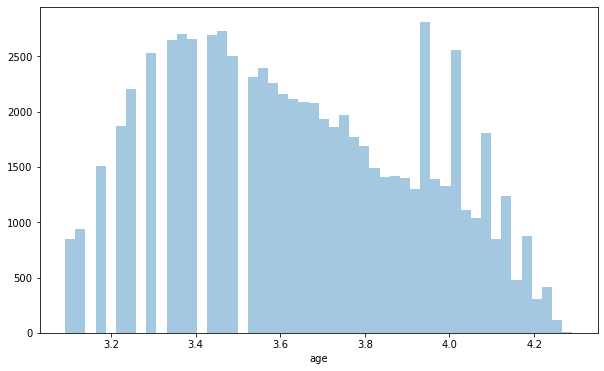

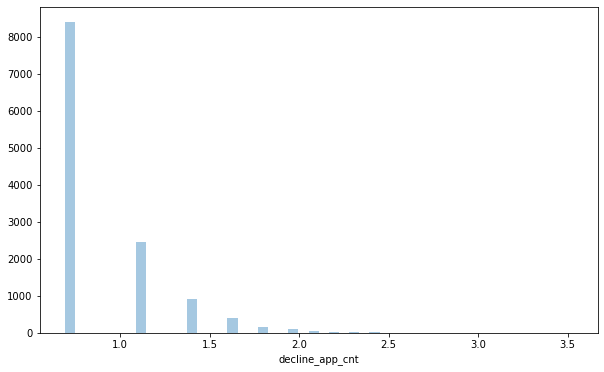

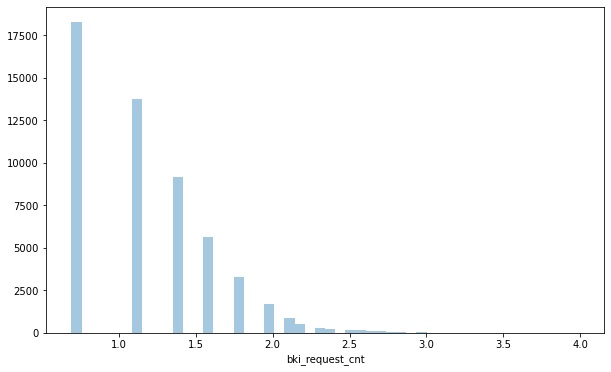

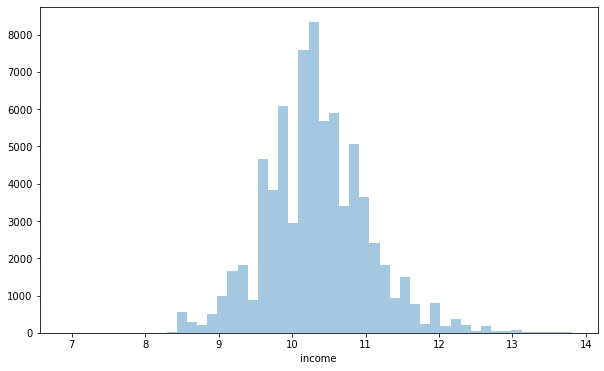

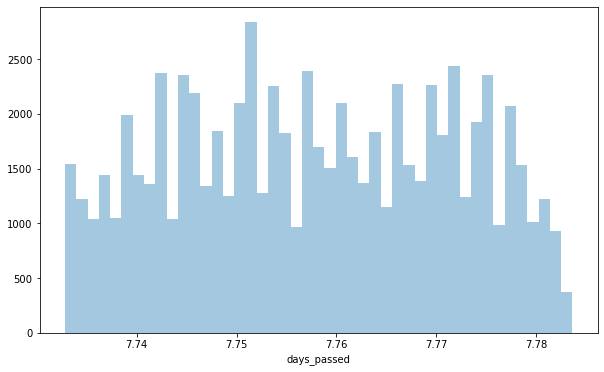

In [75]:
num_cols_log = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income', 'days_passed']
for i in num_cols_log:
    train[i] = np.log(train[i] + 1)
    plt.figure(figsize=(10,6))
    sns.distplot(train[i][train[i] > 0].dropna(), kde = False, rug=False)
    plt.show()

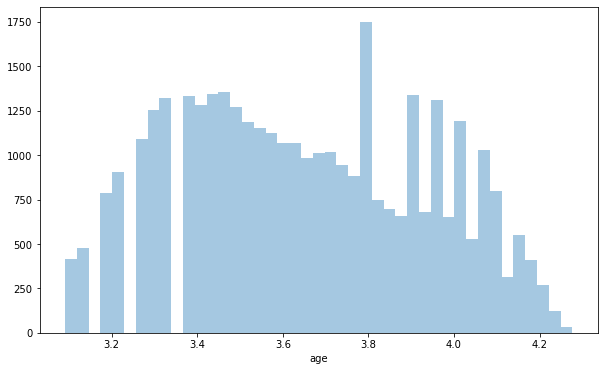

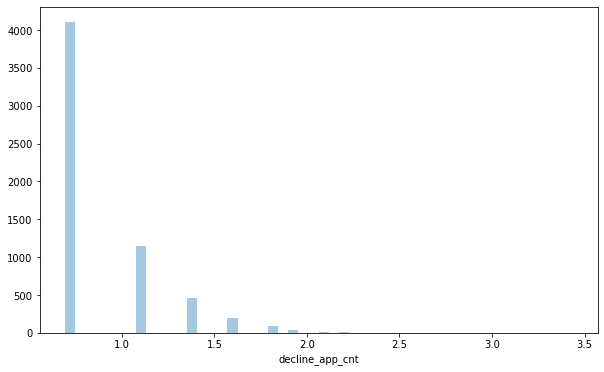

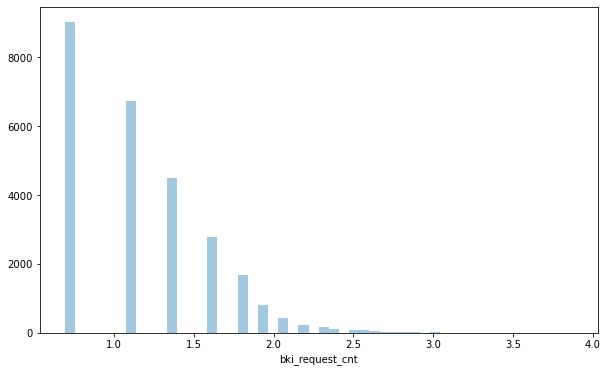

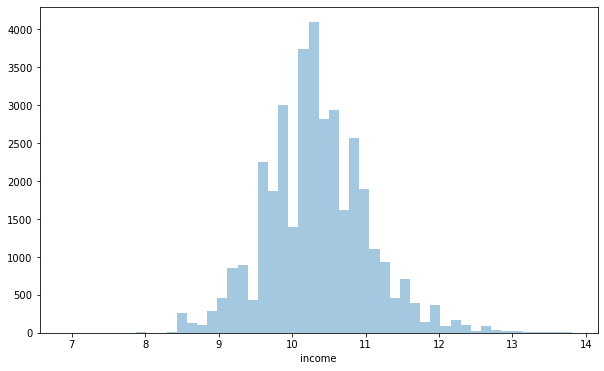

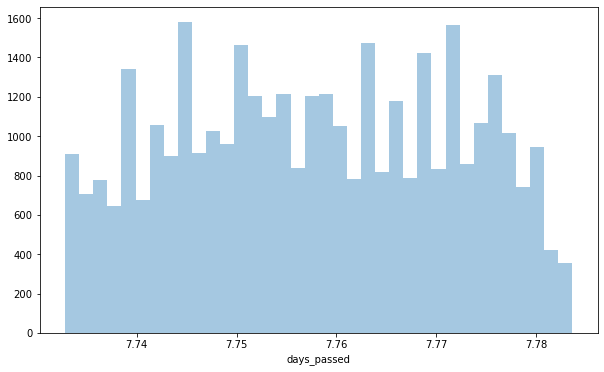

In [76]:
for i in num_cols_log:
    test[i] = np.log(test[i] + 1)
    plt.figure(figsize=(10,6))
    sns.distplot(test[i][test[i] > 0].dropna(), kde = False, rug=False)
    plt.show()

In [77]:
train[num_cols].describe()

,days_passed,age,decline_app_cnt,score_bki,bki_request_cnt,region_rating,income
count,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000
mean,7.757797,3.655332,0.152451,-1.904724,0.878014,56.725701,10.345886
std,0.013728,0.285077,0.362971,0.498231,0.657881,13.055717,0.697702
min,7.732808,3.091042,0.000000,-3.624586,0.000000,20.000000,6.908755
25%,7.745868,3.433987,0.000000,-2.259534,0.000000,50.000000,9.903538
50%,7.757479,3.637586,0.000000,-1.920823,0.693147,50.000000,10.308986
75%,7.769801,3.891820,0.000000,-1.569831,1.386294,60.000000,10.778977
max,7.783641,4.290459,3.526361,0.199773,3.988984,80.000000,13.815512


Построим матрицу корреляций

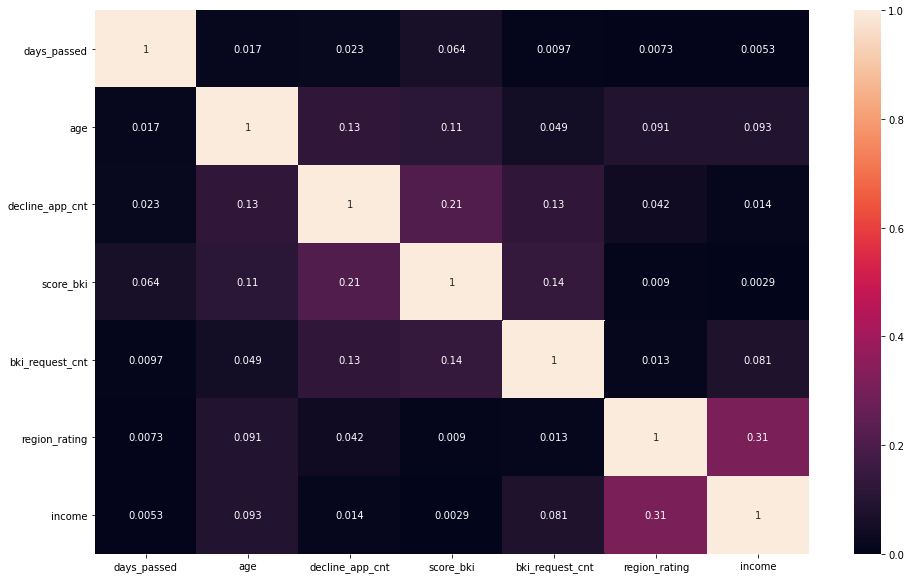

In [78]:
plt.figure(figsize=(16,10))
sns.heatmap(train[num_cols].corr().abs(), vmin=0, vmax=1, annot=True)

Высокой корреляции между признаками не наблюдается

Проанализируем боксплоты для численных переменных

In [79]:
num_cols

['days_passed',
 'age',
 'decline_app_cnt',
 'score_bki',
 'bki_request_cnt',
 'region_rating',
 'income']

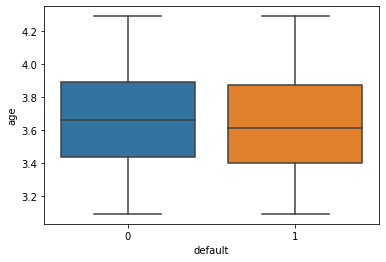

In [80]:
sns.boxplot(x=train.default, y=train.age)

Недефолтные клиенты в среднем старше дефолтных

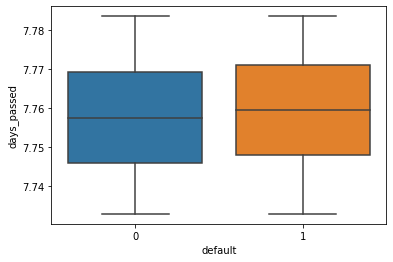

In [81]:
sns.boxplot(x=train.default, y=train.days_passed)

Дефолтные клиенты в среднем оформляли заявки раньше, чем недефолтные. Это может быть связано со множеством факторов, вплоть до эффективности работы системы скоринга в банке в разные моменты времени. Но разница не настолько значительная, чтобы делать какие либо выводы.

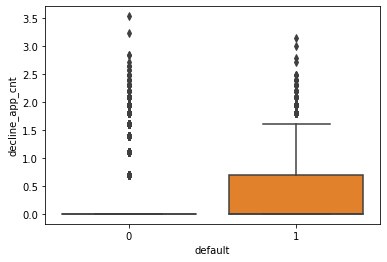

In [82]:
sns.boxplot(x=train.default, y=train.decline_app_cnt)

У дефолтных клиентов количество отклоненных заявок выше, чем у недефолтных

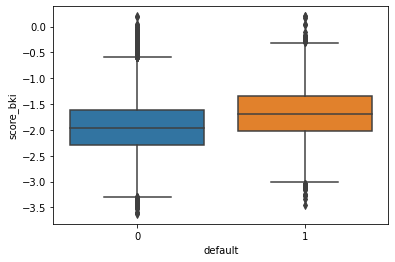

In [83]:
sns.boxplot(x=train.default, y=train.score_bki)

Скоринговый балл в среднем выше у дефолтных клиентов, что довольно необычно (вероятнее всего банк самостоятельно произвел манипуляции с этим признаком, т. к. обычно скоринговый балл положительный от 0 до 850)

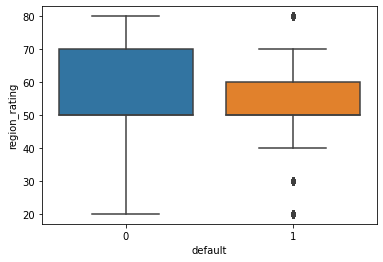

In [84]:
sns.boxplot(x=train.default, y=train.region_rating)

Среднее значение в данном случае больше у недефолтных клиентов, в то время как медианы равны

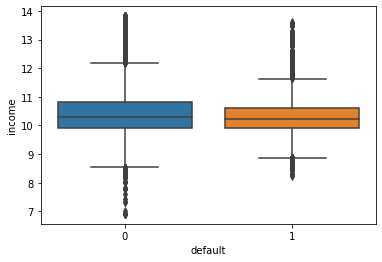

In [85]:
sns.boxplot(x=train.default, y=train.income)

Доход недефолтных клиентов выше, чем доход дефолтных

Далее проанализируем наличие выбросов в численных переменных после логарифмирования.

Без выбросов: 0, 1

'decline_app_cnt'

count    73799.000000
mean         0.152451
std          0.362971
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          3.526361
Name: decline_app_cnt, dtype: float64

25-й перцентиль: 0.0, 75-й перцентиль: 0.0 
IQR: 0.0, Границы выбросов: [0.0, 0.0].


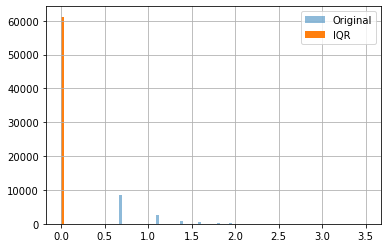

In [86]:
idx = 2
display(num_cols[idx])
my.print_column_hist(train[num_cols[idx]], [0,3.5])

'score_bki'

count    73799.000000
mean        -1.904724
std          0.498231
min         -3.624586
25%         -2.259534
50%         -1.920823
75%         -1.569831
max          0.199773
Name: score_bki, dtype: float64

25-й перцентиль: -2.259533835, 75-й перцентиль: -1.56983126 
IQR: 0.6897025750000001, Границы выбросов: [-3.2940876975, -0.5352773974999998].


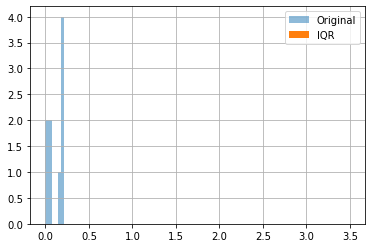

In [87]:
idx = 3
display(num_cols[idx])
my.print_column_hist(train[num_cols[idx]], [0,3.5])

In [88]:
display(train.shape)
train = train.query("-3.5 < score_bki < -0.5")
display(train.shape)

(73799, 22)

(73542, 22)

'bki_request_cnt'

count    73542.000000
mean         0.877020
std          0.656603
min          0.000000
25%          0.000000
50%          0.693147
75%          1.386294
max          3.988984
Name: bki_request_cnt, dtype: float64

25-й перцентиль: 0.0, 75-й перцентиль: 1.3862943611198906 
IQR: 1.3862943611198906, Границы выбросов: [-2.0794415416798357, 3.465735902799726].


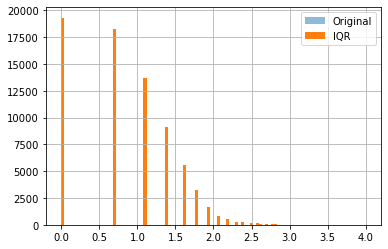

In [89]:
idx = 4
display(num_cols[idx])
my.print_column_hist(train[num_cols[idx]], [0,4])

In [90]:
display(train.shape)
train = train.query("-2.1 < bki_request_cnt < 3.5")
display(train.shape)

(73542, 22)

(73537, 22)

## Преобразование бинарных и категориальных переменных

Преобразуем бинарные переменные при помощи класса LabelEncoder

In [91]:
label_encoder = LabelEncoder()

for column in bin_cols:
    train[column] = label_encoder.fit_transform(train[column])
    test[column] = label_encoder.fit_transform(test[column])

    
# убедимся в преобразовании    
display(train.head())
display(test.head())

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,home_address,work_address,income,sna,first_time,foreign_passport,default,days_passed,app_date_month,app_date_weekday
0,25905,2014-02-01,SCH,1,4.143135,1,1,0.000000,0,-2.008753,...,1,2,9.798183,4,1,0,0,7.770645,2,6
1,63161,2014-03-12,SCH,0,4.094345,0,0,0.000000,0,-1.532276,...,2,3,9.852247,4,1,0,0,7.754053,3,3
2,25887,2014-02-01,SCH,1,3.258097,1,0,1.098612,0,-1.408142,...,1,2,10.308986,1,4,1,0,7.770645,2,6
3,16222,2014-01-23,SCH,0,3.988984,0,0,0.000000,0,-2.057471,...,2,3,9.210440,1,3,0,0,7.774436,1,4
4,101655,2014-04-18,GRD,1,3.891820,0,0,0.000000,1,-1.244723,...,2,3,10.308986,1,4,1,0,7.738052,4,5


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,days_passed,app_date_month,app_date_weekday
0,74835,2014-03-22,GRD,1,3.401197,1,1,0.000000,0,-2.271884,...,50,1,2,10.819798,1,4,0,7.749753,3,6
1,17527,2014-01-24,SCH,0,3.688879,0,0,1.791759,0,-1.504999,...,50,1,2,8.517393,4,3,0,7.774015,1,5
2,75683,2014-03-23,UGR,1,3.931826,1,1,0.000000,0,-1.691339,...,50,1,2,10.308986,1,3,1,7.749322,3,7
3,26883,2014-02-03,SCH,1,4.043051,0,0,0.000000,0,-2.374182,...,40,1,2,9.741027,1,3,0,7.769801,2,1
4,28862,2014-02-04,GRD,0,3.663562,0,0,0.000000,0,-2.487502,...,80,2,3,11.695255,1,3,0,7.769379,2,2


Преобразуем категориальные переменные при помощи OneHotEncoder

In [92]:
x_cat = OneHotEncoder(sparse = False).fit_transform(train[cat_cols].values)
y_cat = OneHotEncoder(sparse = False).fit_transform(test[cat_cols].values)

print(x_cat.shape)
print(y_cat.shape)

(73537, 30)
(36349, 30)


In [93]:
education_dummy = pd.get_dummies(train['education'])
education_dummy.head()

,ACD,GRD,PGR,SCH,UGR
0,0,0,0,1,0
1,0,0,0,1,0
2,0,0,0,1,0
3,0,0,0,1,0
4,0,1,0,0,0


## Значимость непрерывных переменных

Text(0.5, 0, 'F-value')

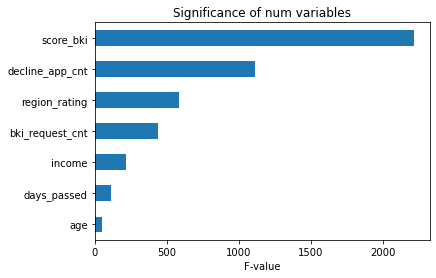

In [94]:
imp_num = Series(f_classif(train[num_cols], train['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')
plt.title('Significance of num variables')
plt.xlabel('F-value')

## Значимость бинарных и категориальных переменных

In [95]:
#print(abc)

Text(0.5, 1.0, 'Significance of bin variables')

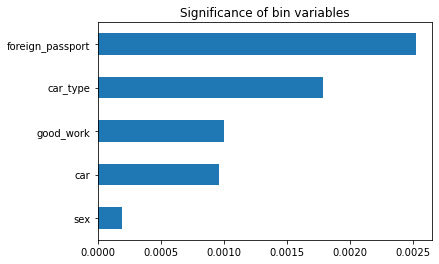

In [96]:
# Значимость бинарных признаков

imp_bin = Series(mutual_info_classif(train[bin_cols], train['default'],
                                     discrete_features =True), index = bin_cols)
imp_bin.sort_values(inplace = True)
imp_bin.plot(kind = 'barh')
plt.title('Significance of bin variables')

Text(0.5, 1.0, 'Significance of cat variables')

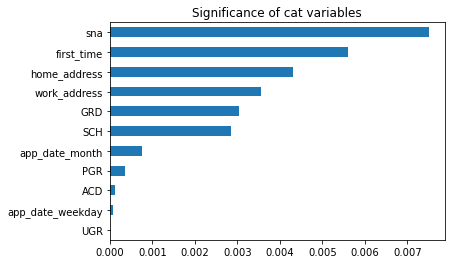

In [97]:
# Значимость категориальных признаков

new_cat_cols = ['app_date_month', 'app_date_weekday', 'home_address', 'work_address', 'sna', 'first_time']

imp_cat = pd.Series(mutual_info_classif(pd.concat([train[new_cat_cols], education_dummy], axis=1),
                                        train['default'], discrete_features =True),
                    index = pd.concat([train[new_cat_cols], education_dummy], axis=1).columns)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')
plt.title('Significance of cat variables')

Исходя из данных графиков можно сделать вывод о малозначимости признака sex и age. А также мы можем увидеть значимость различных степеней образования на наш результат и наибольший вклад приносит признак GRD (graduate).

## Подготовка данных к машинному обучению

In [98]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(2)

x_tr = poly.fit_transform(train[num_cols].values)
y_test = poly.fit_transform(test[num_cols].values)

Стандартизируем числовые переменные

In [99]:
# Scaling num variables

x_num = StandardScaler().fit_transform(x_tr)
y_num = StandardScaler().fit_transform(y_test)
print(x_num)
print(y_num)

[[ 0.          0.55014399  1.10422024 ...  0.         -0.26837123
  -0.57440869]
 [ 0.         -0.14315635  0.99765266 ...  0.         -0.25416892
  -0.51499331]
 [ 0.          0.55014399 -0.82888202 ...  3.54545455  1.49067191
   0.        ]
 ...
 [ 0.         -0.88463113 -0.37535569 ...  3.54545455  1.66108776
   0.47671781]
 [ 0.          1.04089802 -0.51632086 ...  0.         -0.35385178
  -0.92511104]
 [ 0.          0.70851583 -0.17962463 ...  0.         -0.18207962
  -0.20836609]]
[[ 0.         -0.34692282 -0.51632086 ...  0.         -0.0150195
   0.59608245]
 [ 0.          0.68547405  0.11203492 ...  0.         -0.60850326
  -1.86284448]
 [ 0.         -0.3652605   0.64267847 ...  0.         -0.14668999
   0.        ]
 ...
 [ 0.         -0.49384601 -0.37535569 ...  0.          0.0319761
   0.8158145 ]
 [ 0.          0.98859453 -0.66701524 ...  3.54545455  1.44769904
   0.        ]
 [ 0.         -0.25535277  0.05673571 ...  0.         -0.32535177
  -0.76272907]]


И объединим стандартизованные числовые, бинарные и закодированные категориальные переменные в одно признаковое пространство, разделив при этом признаки и целевую переменную.

In [100]:
# Merge

X = np.hstack([x_num, train[bin_cols].values, x_cat])
Y = train['default'].values

id_test = test.client_id
test = np.hstack([y_num, test[bin_cols].values, y_cat])

In [101]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=42, shuffle = True)

## Регуляризация

In [102]:
from sklearn.model_selection import GridSearchCV

# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)

penalty = ['l1', 'l2']
hyperparameters = dict(C=C, penalty=penalty)
model = LogisticRegression()
model.fit(X_train, y_train)

clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

best_penalty = best_model.best_estimator_.get_params()['penalty']
best_с = best_model.best_estimator_.get_params()['C']

print('Лучший penalty:', best_penalty)
print('Лучшее C:', best_с)

Лучший penalty: l2
Лучшее C: 21.544346900318832


Обучим модель

In [103]:
lgr = LogisticRegression(penalty=best_penalty, C=best_с, max_iter=500)
lgr.fit(X_train, y_train)

LogisticRegression(C=21.544346900318832, max_iter=500)

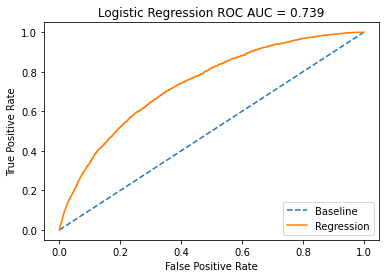

ROC AUC baseline = 0.740
ROC AUC current = 0.739


In [104]:
probs = lgr.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

print("ROC AUC baseline = 0.740")
print("ROC AUC current = %0.3f" % roc_auc)

Обучим модель на всем датасете

In [105]:
lgr = LogisticRegression(penalty=best_penalty, C=best_с, max_iter=500)
lgr.fit(X, Y)
probs = lgr.predict_proba(test)
probs = probs[:,1]

In [106]:
my_submission = pd.DataFrame({'client_id': id_test, 
                            'default': probs})
my_submission.to_csv('submission.csv', index=False)

my_submission

,client_id,default
0,74835,0.045784
1,17527,0.370879
2,75683,0.071023
3,26883,0.075958
4,28862,0.019350
...,...,...
36344,83775,0.383411
36345,106254,0.017185
36346,81852,0.310702
36347,1971,0.227112
